In [1]:

with open('/home/jislam/Documents/gits/reproduce_thesis/chapter_04/extra_scripts/src.py') as f:
    exec(f.read())
with open('/home/jislam/Documents/gits/reproduce_thesis/chapter_04/extra_scripts/tcga_src.py') as f:
    exec(f.read())
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
sns.set(style="whitegrid")

min_optuna=10
hyperparam_epochs=200 #max per trial
hyperparam_trials=100 #number of trials for each model.
n_top_genes=2000
burn_in=10
burn_in_cbnn=5
patience=10
patience_cbnn=10
k=100
validation_ratio=0.2

main_path="/home/jislam/Documents/gits/reproduce_thesis/chapter_04/analysis/"
filter_by="cancerxrisk"
category_labels=[filter_by] # See adata.obs.columns for what categories you can use here. Specify which columns to one-hot-encode and use to inform the models. cell_disease is generated for the interaction.
#group_a=["High Risk"]
#group_b=["Low Risk"]
shared_filter =None
analysis_set="pancancer_tcga"
###########################################
# MUST BE SPECIFIED FOR EACH INQUIRY.
# SEE BOTTOM OF SCRIPT. NEAR THE BOTTOM: 
# when generating the full reports, you 
# will need to specify the following 
# parameters manually. For example.
# To automate this, using group_a
# and group b, with shared_filter
# set to none. Details on the filters
# below.
##########################################
# shared_filter = ["sex=female"] 
# EXACT LABEL in adata.one_hot_encoded.columns.
# If set to None, will not filter. if you want 
# to specify a particular subset of cells, not 
# of the criteria of interest (in this case sex,
# or race would make sense if cell_disease is 
# what I'm interested in)
# filter_criteria_start = ["Tumor"]
# SMART LABEL: searches for the substring in 
# adata.one_hot_encoded.columns. can grab all 
# Tumor with "Tumor" or the specific interaction 
# with ->["cell_disease=beta cell_Tumor"] 
# filter_criteria_goal =["Normal"]
# SMART LABEL: same idea.
########################################




outdir=analysis_set.replace(" ", "_")
if not os.path.exists(outdir):
    os.makedirs(outdir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



rnaseq=pd.read_csv('/home/jislam/Documents/gits/reproduce_thesis/chapter_04/data/tcga_data/EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena',sep="\t")
rnaseq.rename(columns={'sample': 'gene_id'}, inplace=True)
#rnaseq = filter_primary_tumors(rnaseq)
rnaseq = filter_smallest_sample(rnaseq)
clinical =  pd.read_excel('/home/jislam/Documents/gits/reproduce_thesis/chapter_04/data/tcga_data/TCGA-CDR-SupplementalTableS1.xlsx', sheet_name=None)
clinical=clinical['TCGA-CDR'].copy()


adata=build_anndata(rnaseq=rnaseq,clinical=clinical)

adata.obs['ajcc_simplified']=categorize_ajcc_risk(adata.obs['ajcc_pathologic_tumor_stage'])




adata.obs['ajcc_simplified']=categorize_ajcc_risk(adata.obs['ajcc_pathologic_tumor_stage'])
to_filter=group_by_both_obs(adata,"type",'ajcc_simplified')
to_keep=to_filter[~((to_filter["_High Risk"] < 10) | 
          (to_filter["_Low Risk"]  <10) | 
          (to_filter[["_High Risk", "_Low Risk"]].max(axis=1) / to_filter[["_High Risk", "_Low Risk"]].min(axis=1) > 100))
         ].index

adata = adata[adata.obs['type'].isin(to_keep)].copy()
adata = adata[adata.obs['ajcc_simplified'].isin(['_High Risk','_Low Risk'])].copy()
adata.obs["cancerxrisk"]=adata.obs["type"].astype(str)  + adata.obs["ajcc_simplified"].astype(str)
clear_output(wait=True)
adata.obs['cancerxrisk'].value_counts()



import scanpy as sc
import matplotlib.pyplot as plt

# Step 1: Run PCA
sc.pp.pca(adata, n_comps=50)
print("PCA completed.")

# Step 2: Compute neighborhood graph
sc.pp.neighbors(adata, n_pcs=30)  # Use the first 30 principal components
print("Nearest-neighbor graph computed.")

# Step 3: Compute UMAP
sc.tl.umap(adata)
print("UMAP embedding completed.")
adata.obs['ajcc_simplified_umap'] = adata.obs['ajcc_simplified'].str.lstrip('_')
# now swap the labels
adata.obs['ajcc_simplified_umap'] = adata.obs['ajcc_simplified_umap'].replace({
    "High Risk": "High stage",
    "Low Risk" : "Low stage"
})
group_by_both_obs(adata,"type",'ajcc_simplified')


# Step 4: Plot UMAP, colored by 'ajcc_simplified'
sc.pl.umap(adata, color=['ajcc_simplified','type'], frameon=False, title="UMAP colored by AJCC Risk Category")


sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)

# Step 2: Subset to keep only HVGs
adata = adata[:, adata.var['highly_variable']].copy()

# Optional: Check how many genes were selected
print(f" Selected {adata.n_vars} highly variable genes.")
clear_output()
one_hot_labels, num_categories= gosip.one_hot_encode_combinations(adata.obs, category_labels)
adata.one_hot_labels= one_hot_labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [3]:
adata.obs

,Unnamed: 0,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,...,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,sample_code,ajcc_simplified,cancerxrisk,ajcc_simplified_umap
718,8798,TCGA-3N-A9WB,SKCM,71.0,MALE,WHITE,Stage IA,[Not Applicable],NaN,[Not Available],...,518.0,NaN,NaN,1.0,426.0,NaN,06,_Low Risk,SKCM_Low Risk,Low stage
719,8799,TCGA-3N-A9WC,SKCM,82.0,MALE,WHITE,Stage IIA,[Not Applicable],NaN,[Not Available],...,2022.0,NaN,NaN,1.0,1705.0,NaN,06,_High Risk,SKCM_High Risk,High stage
720,8800,TCGA-3N-A9WD,SKCM,82.0,MALE,WHITE,Stage IIIA,[Not Applicable],NaN,[Not Available],...,395.0,NaN,NaN,1.0,306.0,NaN,06,_High Risk,SKCM_High Risk,High stage
721,8801,TCGA-BF-A1PU,SKCM,46.0,FEMALE,WHITE,Stage IIC,[Not Applicable],NaN,[Not Available],...,387.0,NaN,NaN,1.0,484.0,NaN,01,_High Risk,SKCM_High Risk,High stage
722,8802,TCGA-BF-A1PV,SKCM,74.0,FEMALE,WHITE,Stage IIC,[Not Applicable],NaN,[Not Available],...,14.0,NaN,NaN,0.0,14.0,NaN,01,_High Risk,SKCM_High Risk,High stage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10225,9464,TCGA-CG-4472,STAD,49.0,MALE,[Not Available],Stage IV,[Not Applicable],[Not Available],G3,...,365.0,NaN,NaN,1.0,122.0,NaN,01,_High Risk,STAD_High Risk,High stage
10226,9465,TCGA-CG-4474,STAD,67.0,FEMALE,[Not Available],Stage IV,[Not Applicable],"Stomach, Adenocarcinoma, Diffuse Type",G3,...,0.0,NaN,NaN,0.0,0.0,NaN,01,_High Risk,STAD_High Risk,High stage
10227,9466,TCGA-CG-4475,STAD,76.0,MALE,[Not Available],Stage IIB,[Not Applicable],[Not Available],G3,...,699.0,NaN,NaN,0.0,699.0,NaN,01,_High Risk,STAD_High Risk,High stage
10228,9467,TCGA-CG-4476,STAD,69.0,MALE,[Not Available],Stage IIIC,[Not Applicable],"Stomach, Adenocarcinoma, Diffuse Type",G3,...,0.0,NaN,NaN,0.0,0.0,NaN,01,_High Risk,STAD_High Risk,High stage


In [4]:
adata.obs['PFI.time'].max()

np.float64(10334.0)

In [5]:
import pandas as pd

import pandas as pd

def create_two_stage_tables(
    adata,
    type_col: str,
    stage_col: str,
    time_col: str,
    event_col: str
) -> (dict, str):
    """
    Splits adata.obs by the two categories in `stage_col` and, for each stage,
    computes:
      • median_survival    = median(time_col)
      • n_events          = sum(event_col)
      • number of samples = count of rows in that (type_col, stage) subgroup

    Returns
    -------
    tables_dict : dict
        A dict mapping each stage value  to  the corresponding summary DataFrame
        (index = cancer type, columns = [median_survival, n_events, number of samples]).
    combined_latex : str
        A single LaTeX snippet containing both tables side by side using subtable.
    
    Raises
    ------
    ValueError
        If `stage_col` does not have exactly two distinct, non‐NA values in adata.obs.
    """
    # 1) Extract the four columns and drop any rows with NA in any of them
    df = adata.obs[[type_col, stage_col, time_col, event_col]].copy()
    df = df.dropna(subset=[type_col, stage_col, time_col, event_col])

    # 2) Ensure event_col is numeric (0/1). If boolean  to  cast to int.
    if df[event_col].dtype == bool:
        df[event_col] = df[event_col].astype(int)
    
    # 3) Identify unique stages (must be exactly two)
    unique_stages = sorted(df[stage_col].unique())
    if len(unique_stages) != 2:
        raise ValueError(
            f"Expected exactly two categories in `{stage_col}`, but found {unique_stages!r}."
        )
    
    tables_dict = {}
    latex_tables = {}

    # 4) For each of the two stages, compute the 3‐column summary
    for stage in unique_stages:
        sub = df[df[stage_col] == stage]

        #   Group by `type_col` and aggregate:
        #     - median_survival    = median(time_col)
        #     - n_events          = sum(event_col)
        #     - number of samples = count of rows (we can count time_col, since NA were dropped)
        summary = (
            sub
            .groupby(type_col, observed=True)
            .agg(**{
                "median_survival":    (time_col, "median"),
                "n_events":           (event_col, "sum"),
                "number of samples": (time_col, "count")
            })
            .sort_index()
        )

        # Round median_survival to one decimal (optional)
        summary["median_survival"] = summary["median_survival"].round(1)
        # Ensure `number of samples` is integer:
        summary["number of samples"] = summary["number of samples"].astype(int)

        # a) Give the index a name (for LaTeX)
        summary.index.name = type_col

        # b) Store the DataFrame so you can inspect it later if needed
        tables_dict[stage] = summary

        # c) Generate a LaTeX tabular (no outer `table` wrapper here)
        #    Now it will include three columns in the order: 
        #      median_survival, n_events, number of samples
        latex_tbl = summary.to_latex(
            float_format="%.1f",
            index=True,
            na_rep="–"
        )
        latex_tables[stage] = latex_tbl

    # 5) Build a combined LaTeX snippet with two subtable environments side by side.
    s1, s2 = unique_stages
    tbl1 = latex_tables[s1].strip().splitlines()
    tbl2 = latex_tables[s2].strip().splitlines()

    # Helper to indent each line by 4 spaces
    def indent(lines, n=4):
        return [" " * n + line for line in lines]

    tbl1_indented = "\n".join(indent(tbl1))
    tbl2_indented = "\n".join(indent(tbl2))

    combined_latex = (
        r"\begin{table}[ht]" + "\n"
        r"  \centering" + "\n"

        # Subtable for stage 1
        r"  \begin{subtable}[t]{0.45\textwidth}" + "\n"
        r"    \centering" + "\n"
        f"    \\caption{{Stage {s1}}}\n"
        f"{tbl1_indented}\n"
        r"  \end{subtable}" + "\n"

        r"  \hfill" + "\n"

        # Subtable for stage 2
        r"  \begin{subtable}[t]{0.45\textwidth}" + "\n"
        r"    \centering" + "\n"
        f"    \\caption{{Stage {s2}}}\n"
        f"{tbl2_indented}\n"
        r"  \end{subtable}" + "\n"


        r"\end{table}"
    )

    return tables_dict, combined_latex

summary_df, latex_table = create_two_stage_tables(
    adata,
    type_col="type",
    stage_col="ajcc_simplified_umap",
    time_col="PFI.time",
    event_col="PFI"
)
print(latex_table)

\begin{table}[ht]
  \centering
  \begin{subtable}[t]{0.45\textwidth}
    \centering
    \caption{Stage High stage}
    \begin{tabular}{lrrr}
    \toprule
     & median_survival & n_events & number of samples \\
    type &  &  &  \\
    \midrule
    BRCA & 742.0 & 121.0 & 889 \\
    CHOL & 264.0 & 10.0 & 17 \\
    COAD & 549.0 & 112.0 & 364 \\
    ESCA & 362.0 & 68.0 & 143 \\
    HNSC & 550.5 & 161.0 & 418 \\
    KICH & 1897.0 & 10.0 & 45 \\
    KIRC & 648.0 & 132.0 & 261 \\
    KIRP & 408.0 & 36.0 & 87 \\
    LIHC & 260.0 & 101.0 & 175 \\
    LUAD & 441.0 & 116.0 & 227 \\
    LUSC & 481.0 & 88.0 & 250 \\
    MESO & 376.0 & 51.0 & 74 \\
    PAAD & 363.5 & 97.0 & 154 \\
    READ & 585.5 & 32.0 & 122 \\
    SKCM & 542.0 & 221.0 & 342 \\
    STAD & 385.0 & 120.0 & 333 \\
    TGCT & 2241.0 & 3.0 & 26 \\
    THCA & 813.0 & 33.0 & 219 \\
    \bottomrule
    \end{tabular}
  \end{subtable}
  \hfill
  \begin{subtable}[t]{0.45\textwidth}
    \centering
    \caption{Stage Low stage}
    \begin{tab

In [6]:
import pandas as pd

def create_two_stage_latex(
    adata,
    type_col: str,
    stage_col: str,
    time_col: str,
    event_col: str
) -> str:
    """
    Splits adata.obs by the two categories in `stage_col`, and for each stage:
      • computes median_survival = median(time_col)
      • computes n_events       = sum(event_col)

    Then it builds one LaTeX string containing TWO subtables side by side,
    formatted exactly (with indentation) so that you can copy & paste this
    output directly into your .tex file.

    Parameters
    ----------
    adata : AnnData
        Anndata whose .obs has the four named columns.
    type_col : str
        Column name for “cancer type” (will be used as the leftmost column).
    stage_col : str
        Column name for “cancer stage” (must have exactly two unique values).
    time_col : str
        Column name for survival time (numeric).
    event_col : str
        Column name for event flag (0/1).

    Returns
    -------
    combined_latex : str
        A single LaTeX snippet (with two subtables) ready to copy & paste.
    """
    # 1) Extract the relevant columns and drop rows with any missing values.
    df = adata.obs[[type_col, stage_col, time_col, event_col]].copy()
    df = df.dropna(subset=[type_col, stage_col, time_col, event_col])

    # 2) If event_col is boolean, cast to int so sum() yields an integer count.
    if df[event_col].dtype == bool:
        df[event_col] = df[event_col].astype(int)

    # 3) Find exactly two stages
    unique_stages = sorted(df[stage_col].unique())
    if len(unique_stages) != 2:
        raise ValueError(
            f"Expected exactly two categories in `{stage_col}`, but found {unique_stages!r}."
        )

    # 4) For each stage, compute the summary DataFrame (index = type_col).
    tables_dict = {}
    for stage in unique_stages:
        sub = df[df[stage_col] == stage]
        summary = (
            sub
            .groupby(type_col, observed=True)
            .agg(
                median_survival=(time_col, "median"),
                n_events=(event_col, "sum")
            )
            .sort_index()
        )
        # Round median_survival to 1 decimal place
        summary["median_survival"] = summary["median_survival"].round(1)
        # Ensure integer type for n_events
        summary["n_events"] = summary["n_events"].astype(int)
        tables_dict[stage] = summary

    # 5) Build two tabular blocks as lists of lines, exactly how we want them formatted.
    def build_tabular_lines(stage_label, df_summary):
        """
        Returns a list of strings, each string = one line of LaTeX, for a single subtable.
        We assume df_summary.index.name == type_col, columns = ["median_survival", "n_events"].
        """
        lines = []
        # 5a) Header lines: begin{tabular}, \toprule, column heads
        lines.append(r"\begin{tabular}{lrr}")
        lines.append(r"  \toprule")
        # column headings
        #   - We want: cancer_type & median_survival & n_events \\
        col_header = f"  {type_col} & median_survival & n_events \\\\"
        #    Note: If type_col has underscores, the user will have to escape them in their .tex
        #    or we can replace "_" with "\_" below.
        lines.append(col_header)
        lines.append(r"  \midrule")

        # 5b) One row per index (cancer type)
        for ctype, row in df_summary.iterrows():
            median_val = f"{row['median_survival']:.1f}"
            events_val = f"{row['n_events']}"
            # Pad the cancer_type so that columns roughly align in a monospaced editor.
            # (This is purely aesthetic; LaTeX will realign anyway.)
            ctype_str = str(ctype)
            # If you need to escape underscores in ctype_str:
            ctype_str = ctype_str.replace("_", r"\_")

            # Format: "Breast       & 502.0            & 10        \\"
            # We can use fixed-width fields for readability, but not strictly necessary in LaTeX.
            line = f"  {ctype_str:<12} & {median_val:<16} & {events_val:<8} \\\\"
            lines.append(line)

        # 5c) Bottom rule and end{tabular}
        lines.append(r"  \bottomrule")
        lines.append(r"\end{tabular}")
        return lines

    # Build lines for stage1 and stage2
    stage1, stage2 = unique_stages
    tab1_lines = build_tabular_lines(stage1, tables_dict[stage1])
    tab2_lines = build_tabular_lines(stage2, tables_dict[stage2])

    # 6) Now assemble the full LaTeX snippet with proper indentation
    out_lines = []
    out_lines.append(r"\begin{table}[ht]")
    out_lines.append(r"  \centering")

    # Subtable 1
    out_lines.append(r"  \begin{subtable}[t]{0.45\textwidth}")
    out_lines.append(r"    \centering")
    out_lines.append(f"    \\caption{{Stage {stage1}}}")
    # indent each line of tab1_lines by 4 spaces so it nests correctly
    for ln in tab1_lines:
        out_lines.append("    " + ln)
    out_lines.append(r"  \end{subtable}")

    out_lines.append(r"  \hfill")

    # Subtable 2
    out_lines.append(r"  \begin{subtable}[t]{0.45\textwidth}")
    out_lines.append(r"    \centering")
    out_lines.append(f"    \\caption{{Stage {stage2}}}")
    for ln in tab2_lines:
        out_lines.append("    " + ln)
    out_lines.append(r"  \end{subtable}")

    # Overall caption
    # Escape underscore in type_col if needed
    type_col_tex = type_col.replace("_", r"\_")
    out_lines.append(
        r"  \caption{}"
    )
    out_lines.append(r"\end{table>")

    # Join with newline characters. When you print this string, you’ll see exactly what you copy-paste.
    combined_latex = "\n".join(out_lines)
    return combined_latex
latex_table = create_two_stage_latex(
    adata,
    type_col="type",
    stage_col="ajcc_simplified_umap",
    time_col="PFI.time",
    event_col="PFI"
)
latex_table 

'\\begin{table}[ht]\n  \\centering\n  \\begin{subtable}[t]{0.45\\textwidth}\n    \\centering\n    \\caption{Stage High stage}\n    \\begin{tabular}{lrr}\n      \\toprule\n      type & median_survival & n_events \\\\\n      \\midrule\n      BRCA         & 742.0            & 121.0    \\\\\n      CHOL         & 264.0            & 10.0     \\\\\n      COAD         & 549.0            & 112.0    \\\\\n      ESCA         & 362.0            & 68.0     \\\\\n      HNSC         & 550.5            & 161.0    \\\\\n      KICH         & 1897.0           & 10.0     \\\\\n      KIRC         & 648.0            & 132.0    \\\\\n      KIRP         & 408.0            & 36.0     \\\\\n      LIHC         & 260.0            & 101.0    \\\\\n      LUAD         & 441.0            & 116.0    \\\\\n      LUSC         & 481.0            & 88.0     \\\\\n      MESO         & 376.0            & 51.0     \\\\\n      PAAD         & 363.5            & 97.0     \\\\\n      READ         & 585.5            & 32.0     \\

In [7]:
import pandas as pd

def create_two_stage_tables(
    adata,
    type_col: str,
    stage_col: str,
    time_col: str,
    event_col: str
) -> (dict, str):
    """
    Splits adata.obs by the two categories in `stage_col` and, for each stage,
    computes:
      • median_survival    = median(time_col)
      • n_events           = sum(event_col)
      • number of samples  = count of rows in that (type_col, stage) subgroup

    It then builds TWO subtables side by side, each wrapped in
    \resizebox{\linewidth}{!}{…} so that they each occupy exactly 0.45\textwidth
    and cannot overflow the page margins.

    Returns
    -------
    tables_dict : dict
        Maps each stage value  to  the corresponding summary DataFrame
        (index = cancer type, columns = [median_survival, n_events, number of samples]).
    combined_latex : str
        A single LaTeX snippet containing both subtables side by side.

    Raises
    ------
    ValueError
        If `stage_col` does not have exactly two distinct, non‐NA values in adata.obs.
    """
    # 1) Extract the four columns and drop any rows with NA
    df = adata.obs[[type_col, stage_col, time_col, event_col]].copy()
    df = df.dropna(subset=[type_col, stage_col, time_col, event_col])

    # 2) Ensure event_col is numeric (0/1). If boolean  to  cast to int.
    if df[event_col].dtype == bool:
        df[event_col] = df[event_col].astype(int)

    # 3) Identify unique stages (must be exactly two)
    unique_stages = sorted(df[stage_col].unique())
    if len(unique_stages) != 2:
        raise ValueError(
            f"Expected exactly two categories in `{stage_col}`, but found {unique_stages!r}."
        )

    tables_dict = {}
    # We will build each subtable “manually” as a list of lines
    latex_tables = {}

    # 4) For each of the two stages, compute the summary (median_survival, n_events, number of samples)
    for stage in unique_stages:
        sub = df[df[stage_col] == stage]

        summary = (
            sub
            .groupby(type_col, observed=True)
            .agg(**{
                "median_survival":    (time_col, "median"),
                "n_events":           (event_col, "sum"),
                "number of samples": (time_col, "count")
            })
            .sort_index()
        )
        # Round median_survival to one decimal place
        summary["median_survival"] = summary["median_survival"].round(1)
        # Ensure “number of samples” is an integer
        summary["number of samples"] = summary["number of samples"].astype(int)

        # Name the index so that it shows up as the left‐column header in LaTeX
        summary.index.name = type_col

        tables_dict[stage] = summary

        # Build a list of lines corresponding to:
        #   \begin{tabular}{lrrr} … \end{tabular}
        # but with custom column headers:
        #   type_col  & \shortstack{median\\survival} & \texttt{\#} events & \texttt{\#} of samples \\

        def build_tabular_lines(df_summary):
            lines = []

            # 5a) Begin tabular: 4 columns: 1 left‐aligned + 3 right‐aligned
            lines.append(r"\begin{tabular}{lrrr}")
            lines.append(r"  \toprule")

            # 5b) Custom header row.
            #     - First column = type_col
            #     - Second column = median (on one line) \\ survival (on next line)
            #     - Third column = \texttt{\#} events
            #     - Fourth column = \texttt{\#} of samples
            #
            #   We use \shortstack{median\\survival} to break “median” / “survival” into two lines.
            #   We also wrap “#” in \texttt{…} so it uses a typewriter font.
            header_line = (
                fr"  {type_col} "
                r"& "  # column separator
                r"\shortstack{median\\survival} "
                r"& "
                r"\texttt{\#} events "
                r"& "
                r"\texttt{\#} of samples "
                r"\\"
            )
            lines.append(header_line)
            lines.append(r"  \midrule")

            # 5c) One data row per cancer type
            for ctype, row in df_summary.iterrows():
                # Escape underscores in ctype so LaTeX doesn’t choke
                ctype_tex = str(ctype).replace("_", r"\_")
                median_val = f"{row['median_survival']:.1f}"
                events_val = f"{row['n_events']}"
                n_samps = f"{row['number of samples']}"

                # Format each cell with some padding (for human‐readable copy/paste).
                #   “\\” at the end is the LaTeX newline for that row.
                line = (
                    fr"  {ctype_tex:<12} "
                    r"& "
                    fr"{median_val:<16} "
                    r"& "
                    fr"{events_val:<8} "
                    r"& "
                    fr"{n_samps:<12} "
                    r"\\"
                )
                lines.append(line)

            lines.append(r"  \bottomrule")
            lines.append(r"\end{tabular}")
            return lines

        latex_tables[stage] = build_tabular_lines(summary)

    # 6) Now wrap each “tabular” in \resizebox{\linewidth}{!}{…} so it can’t overflow 0.45\textwidth
    def wrap_resizebox(tabular_lines):
        out = []
        # Indent 4 spaces, then \resizebox
        out.append(r"    \resizebox{\linewidth}{!}{")
        for ln in tabular_lines:
            # Indent 6 spaces for each original tabular line
            out.append("      " + ln)
        out.append(r"    }")
        return out

    s1, s2 = unique_stages
    tab1_resized = wrap_resizebox(latex_tables[s1])
    tab2_resized = wrap_resizebox(latex_tables[s2])

    # 7) Assemble the full LaTeX block—with two subtables side by side
    out_lines = []
    out_lines.append(r"\begin{table}[ht]")
    out_lines.append(r"  \centering")
    out_lines.append(r"  %%% Requires: \usepackage{graphicx}, \usepackage{caption}, \usepackage{subcaption}")

    # Subtable for stage 1
    out_lines.append(r"  \begin{subtable}[t]{0.45\textwidth}")
    out_lines.append(r"    \centering")
    out_lines.append(f"    \\caption{{Stage {s1}}}")
    out_lines.extend(tab1_resized)
    out_lines.append(r"  \end{subtable}")

    out_lines.append(r"  \hfill")

    # Subtable for stage 2
    out_lines.append(r"  \begin{subtable}[t]{0.45\textwidth}")
    out_lines.append(r"    \centering")
    out_lines.append(f"    \\caption{{Stage {s2}}}")
    out_lines.extend(tab2_resized)
    out_lines.append(r"  \end{subtable}")

    # Overall caption (escape underscore in type_col if needed)
    type_col_tex = type_col.replace("_", r"\_")
    out_lines.append(
        f"  \\caption{{Median survival (days), number of events, and number of samples by {type_col_tex} for each stage}}"
    )
    out_lines.append(r"\end{table}")

    combined_latex = "\n".join(out_lines)
    return tables_dict, combined_latex
sum_df,latex_table = create_two_stage_tables(
    adata,
    type_col="type",
    stage_col="ajcc_simplified_umap",
    time_col="PFI.time",
    event_col="PFI"
)
print(latex_table)

\begin{table}[ht]
  \centering
  %%% Requires: \usepackage{graphicx}, \usepackage{caption}, \usepackage{subcaption}
  \begin{subtable}[t]{0.45\textwidth}
    \centering
    \caption{Stage High stage}
    \resizebox{\linewidth}{!}{
      \begin{tabular}{lrrr}
        \toprule
        type & \shortstack{median\\survival} & \texttt{\#} events & \texttt{\#} of samples \\
        \midrule
        BRCA         & 742.0            & 121.0    & 889.0        \\
        CHOL         & 264.0            & 10.0     & 17.0         \\
        COAD         & 549.0            & 112.0    & 364.0        \\
        ESCA         & 362.0            & 68.0     & 143.0        \\
        HNSC         & 550.5            & 161.0    & 418.0        \\
        KICH         & 1897.0           & 10.0     & 45.0         \\
        KIRC         & 648.0            & 132.0    & 261.0        \\
        KIRP         & 408.0            & 36.0     & 87.0         \\
        LIHC         & 260.0            & 101.0    & 175.0   

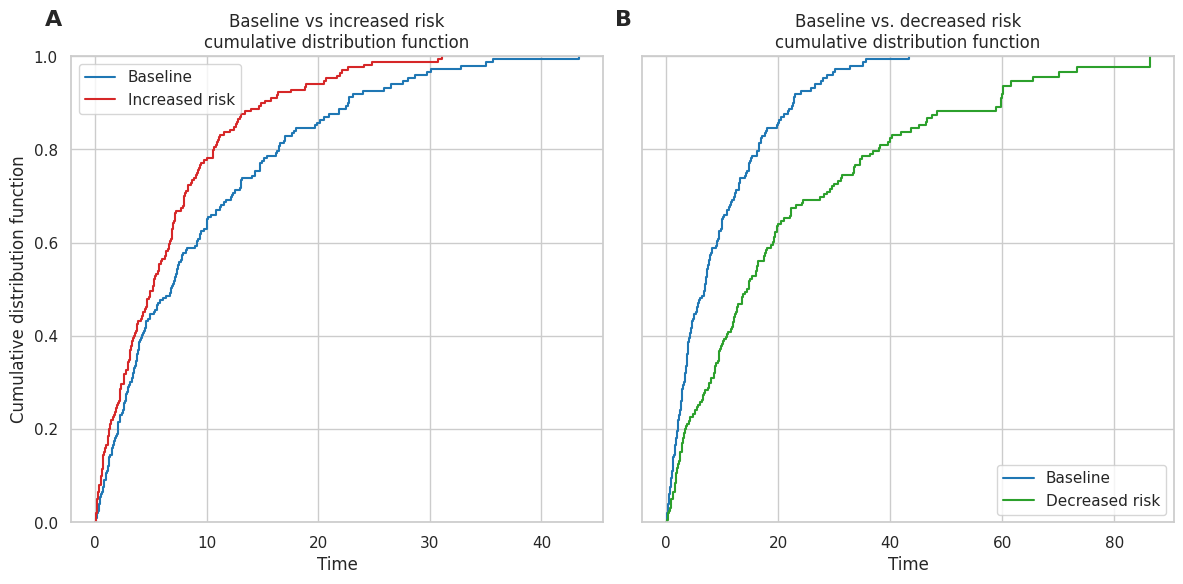

<Figure size 640x480 with 0 Axes>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── 1) SIMULATE DATA WITH UNIFORM (RANDOM) CENSORING ──────────────────────────

np.random.seed(42)
n = 200  # subjects per group

# True hazard rates
hazard_baseline   = 0.10
hazard_increased  = 0.15
hazard_decreased  = 0.05

# 1a) Simulate event times from Exponential(hazard)
event_baseline  = np.random.exponential(scale=1/hazard_baseline,  size=n)
event_increased = np.random.exponential(scale=1/hazard_increased, size=n)
event_decreased = np.random.exponential(scale=1/hazard_decreased, size=n)

# 1b) Determine a “maximum follow‐up” time for uniform censoring:
#     here we take the maximum of all event times across all groups
max_event_time = np.max(np.concatenate([event_baseline, event_increased, event_decreased]))

# 1c) Simulate censoring times from Uniform(0, max_event_time)
censor_baseline  = np.random.uniform(0, max_event_time, size=n)
censor_increased = np.random.uniform(0, max_event_time, size=n)
censor_decreased = np.random.uniform(0, max_event_time, size=n)

# 1d) Observed time = min(event_time, censor_time); event indicator = (event_time <= censor_time)
time_baseline  = np.minimum(event_baseline, censor_baseline)
event_obs_baseline = (event_baseline <= censor_baseline).astype(int)

time_increased = np.minimum(event_increased, censor_increased)
event_obs_increased = (event_increased <= censor_increased).astype(int)

time_decreased = np.minimum(event_decreased, censor_decreased)
event_obs_decreased = (event_decreased <= censor_decreased).astype(int)

# 1e) Put everything into a single DataFrame
df = pd.DataFrame({
    "time":  np.concatenate([time_baseline, time_increased, time_decreased]),
    "event": np.concatenate([event_obs_baseline, event_obs_increased, event_obs_decreased]),
    "group": (["baseline"]*n) + (["increased"]*n) + (["decreased"]*n)
})

# ── 2) KAPLAN–MEIER SURVIVAL FUNCTION (UNCHANGED) ──────────────────────────────

def compute_km(time_arr, event_arr):
    """
    Returns (times, S_times), where S_times is the KM estimate at each distinct event time.
    Also prepends t=0 with S(0)=1.0.
    """
    df_km = pd.DataFrame({"time": time_arr, "event": event_arr}).sort_values("time")
    event_times = np.sort(df_km.loc[df_km["event"] == 1, "time"].unique())

    surv = 1.0
    times = [0.0]
    surv_probs = [1.0]

    for t in event_times:
        n_risk = np.sum(df_km["time"] >= t)
        d_i    = np.sum((df_km["time"] == t) & (df_km["event"] == 1))
        surv  *= (1 - d_i / n_risk)
        times.append(t)
        surv_probs.append(surv)

    return np.array(times), np.array(surv_probs)

# 2a) Compute KM for each group
times_base, surv_base = compute_km(
    df.loc[df["group"] == "baseline", "time"].values,
    df.loc[df["group"] == "baseline", "event"].values
)
times_inc, surv_inc = compute_km(
    df.loc[df["group"] == "increased", "time"].values,
    df.loc[df["group"] == "increased", "event"].values
)
times_dec, surv_dec = compute_km(
    df.loc[df["group"] == "decreased", "time"].values,
    df.loc[df["group"] == "decreased", "event"].values
)

# ── 3) COMPUTE cumulative distribution function = 1 − S(t) ─────────────────────────────────

ci_base = 1 - surv_base
ci_inc  = 1 - surv_inc
ci_dec  = 1 - surv_dec

# ── 4) PLOTTING cumulative distribution function SIDE BY SIDE ──────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Panel A: Baseline vs Increased Risk
ax1 = axes[0]
ax1.step(times_base, ci_base, where="post", label="Baseline",       color="tab:blue")
ax1.step(times_inc,  ci_inc,  where="post", label="Increased risk", color="tab:red")
ax1.set_title("Baseline vs increased risk\ncumulative distribution function")
ax1.set_xlabel("Time")
ax1.set_ylabel("Cumulative distribution function")
ax1.set_ylim(0, 1)
ax1.legend()

# Add “A” at top‐left inside the axes (2% from left, 95% from bottom)
ax1.text(
    -0.05, 1.1, "A",
    transform=ax1.transAxes,
    fontsize=16,
    fontweight="bold",
    va="top"
)

# Panel B: Baseline vs Decreased Risk
ax2 = axes[1]
ax2.step(times_base, ci_base, where="post", label="Baseline",       color="tab:blue")
ax2.step(times_dec,  ci_dec,  where="post", label="Decreased risk", color="tab:green")
ax2.set_title("Baseline vs. decreased risk\ncumulative distribution function")
ax2.set_xlabel("Time")
ax2.set_ylim(0, 1)
ax2.legend()

# Add “B” at top‐left inside the axes
ax2.text(
    -0.05, 1.1, "B",
    transform=ax2.transAxes,
    fontsize=16,
    fontweight="bold",
    va="top"
)

plt.tight_layout()
plt.show()

plt.tight_layout()
fig.savefig('Survival_score_intuition.png')
plt.show()


In [9]:


group_by_both_obs(adata,"type",'ajcc_simplified')

ajcc_simplified,_High Risk,_Low Risk
type,,
BRCA,889,181
CHOL,17,19
COAD,364,74
ESCA,143,18
HNSC,418,27
KICH,45,20
KIRC,261,267
KIRP,87,171
LIHC,175,171


/tmp/ipykernel_55492/924717147.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]


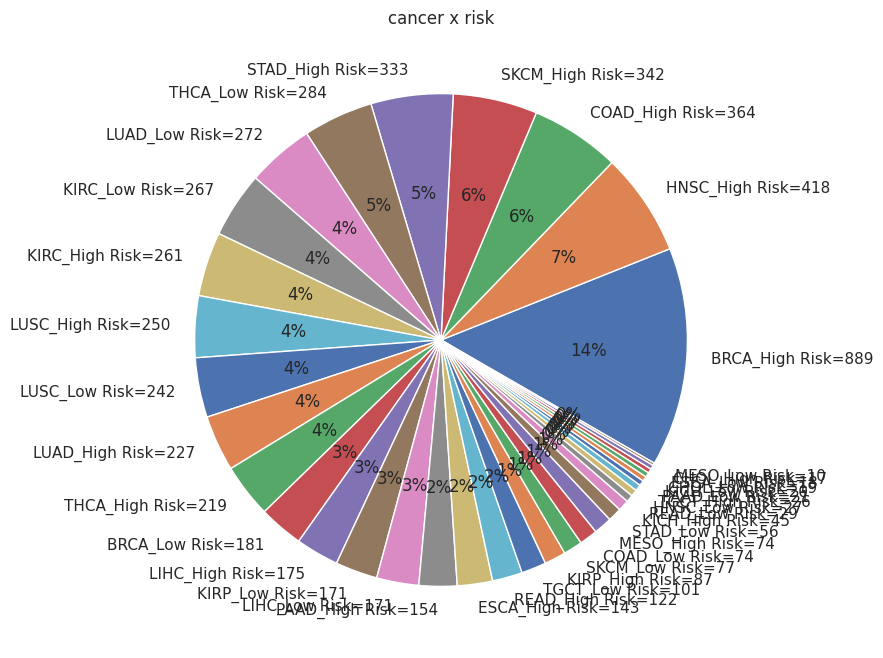

/tmp/ipykernel_55492/924717147.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]


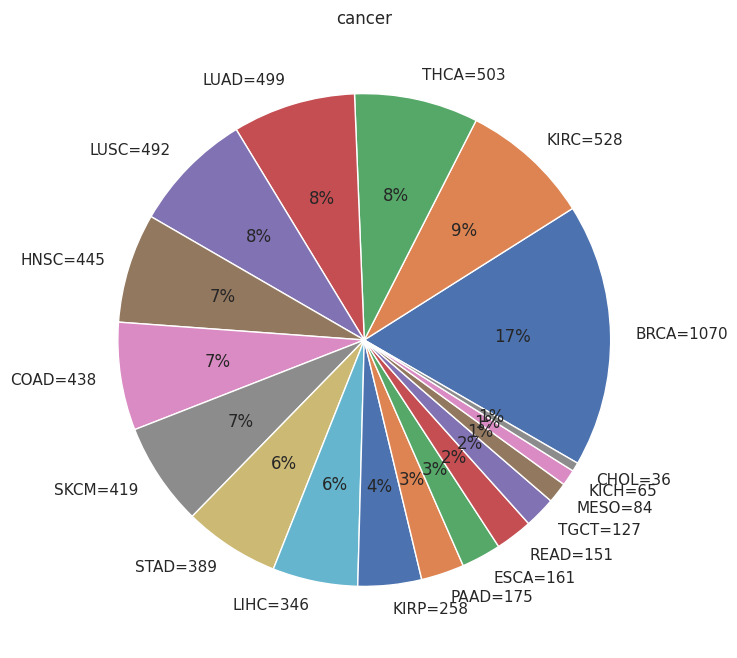

/tmp/ipykernel_55492/924717147.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]


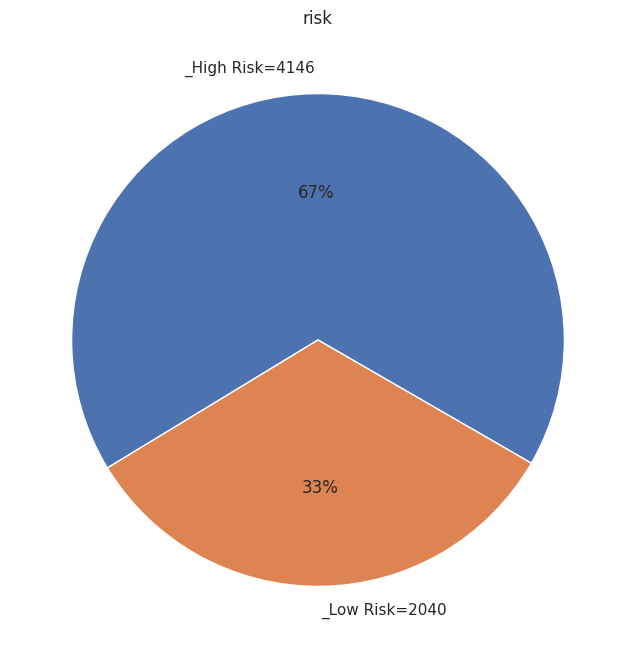

In [10]:
# Extract the column data
column_data = adata.obs[filter_by]

# Count the occurrences of each unique value
value_counts = column_data.value_counts()
value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%.0f%%', startangle=-30)
plt.title('cancer x risk')
plt.show()


column_data = adata.obs['type']

# Count the occurrences of each unique value
value_counts = column_data.value_counts()
value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%.0f%%', startangle=-30)
plt.title('cancer')
plt.show()


column_data = adata.obs['ajcc_simplified']

# Count the occurrences of each unique value
value_counts = column_data.value_counts()
value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%.0f%%', startangle=-30)
plt.title('risk')
plt.show()

In [11]:
adata.obs


,Unnamed: 0,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,...,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,sample_code,ajcc_simplified,cancerxrisk,ajcc_simplified_umap
718,8798,TCGA-3N-A9WB,SKCM,71.0,MALE,WHITE,Stage IA,[Not Applicable],NaN,[Not Available],...,518.0,NaN,NaN,1.0,426.0,NaN,06,_Low Risk,SKCM_Low Risk,Low stage
719,8799,TCGA-3N-A9WC,SKCM,82.0,MALE,WHITE,Stage IIA,[Not Applicable],NaN,[Not Available],...,2022.0,NaN,NaN,1.0,1705.0,NaN,06,_High Risk,SKCM_High Risk,High stage
720,8800,TCGA-3N-A9WD,SKCM,82.0,MALE,WHITE,Stage IIIA,[Not Applicable],NaN,[Not Available],...,395.0,NaN,NaN,1.0,306.0,NaN,06,_High Risk,SKCM_High Risk,High stage
721,8801,TCGA-BF-A1PU,SKCM,46.0,FEMALE,WHITE,Stage IIC,[Not Applicable],NaN,[Not Available],...,387.0,NaN,NaN,1.0,484.0,NaN,01,_High Risk,SKCM_High Risk,High stage
722,8802,TCGA-BF-A1PV,SKCM,74.0,FEMALE,WHITE,Stage IIC,[Not Applicable],NaN,[Not Available],...,14.0,NaN,NaN,0.0,14.0,NaN,01,_High Risk,SKCM_High Risk,High stage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10225,9464,TCGA-CG-4472,STAD,49.0,MALE,[Not Available],Stage IV,[Not Applicable],[Not Available],G3,...,365.0,NaN,NaN,1.0,122.0,NaN,01,_High Risk,STAD_High Risk,High stage
10226,9465,TCGA-CG-4474,STAD,67.0,FEMALE,[Not Available],Stage IV,[Not Applicable],"Stomach, Adenocarcinoma, Diffuse Type",G3,...,0.0,NaN,NaN,0.0,0.0,NaN,01,_High Risk,STAD_High Risk,High stage
10227,9466,TCGA-CG-4475,STAD,76.0,MALE,[Not Available],Stage IIB,[Not Applicable],[Not Available],G3,...,699.0,NaN,NaN,0.0,699.0,NaN,01,_High Risk,STAD_High Risk,High stage
10228,9467,TCGA-CG-4476,STAD,69.0,MALE,[Not Available],Stage IIIC,[Not Applicable],"Stomach, Adenocarcinoma, Diffuse Type",G3,...,0.0,NaN,NaN,0.0,0.0,NaN,01,_High Risk,STAD_High Risk,High stage


/tmp/ipykernel_55492/130274569.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_55492/130274569.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


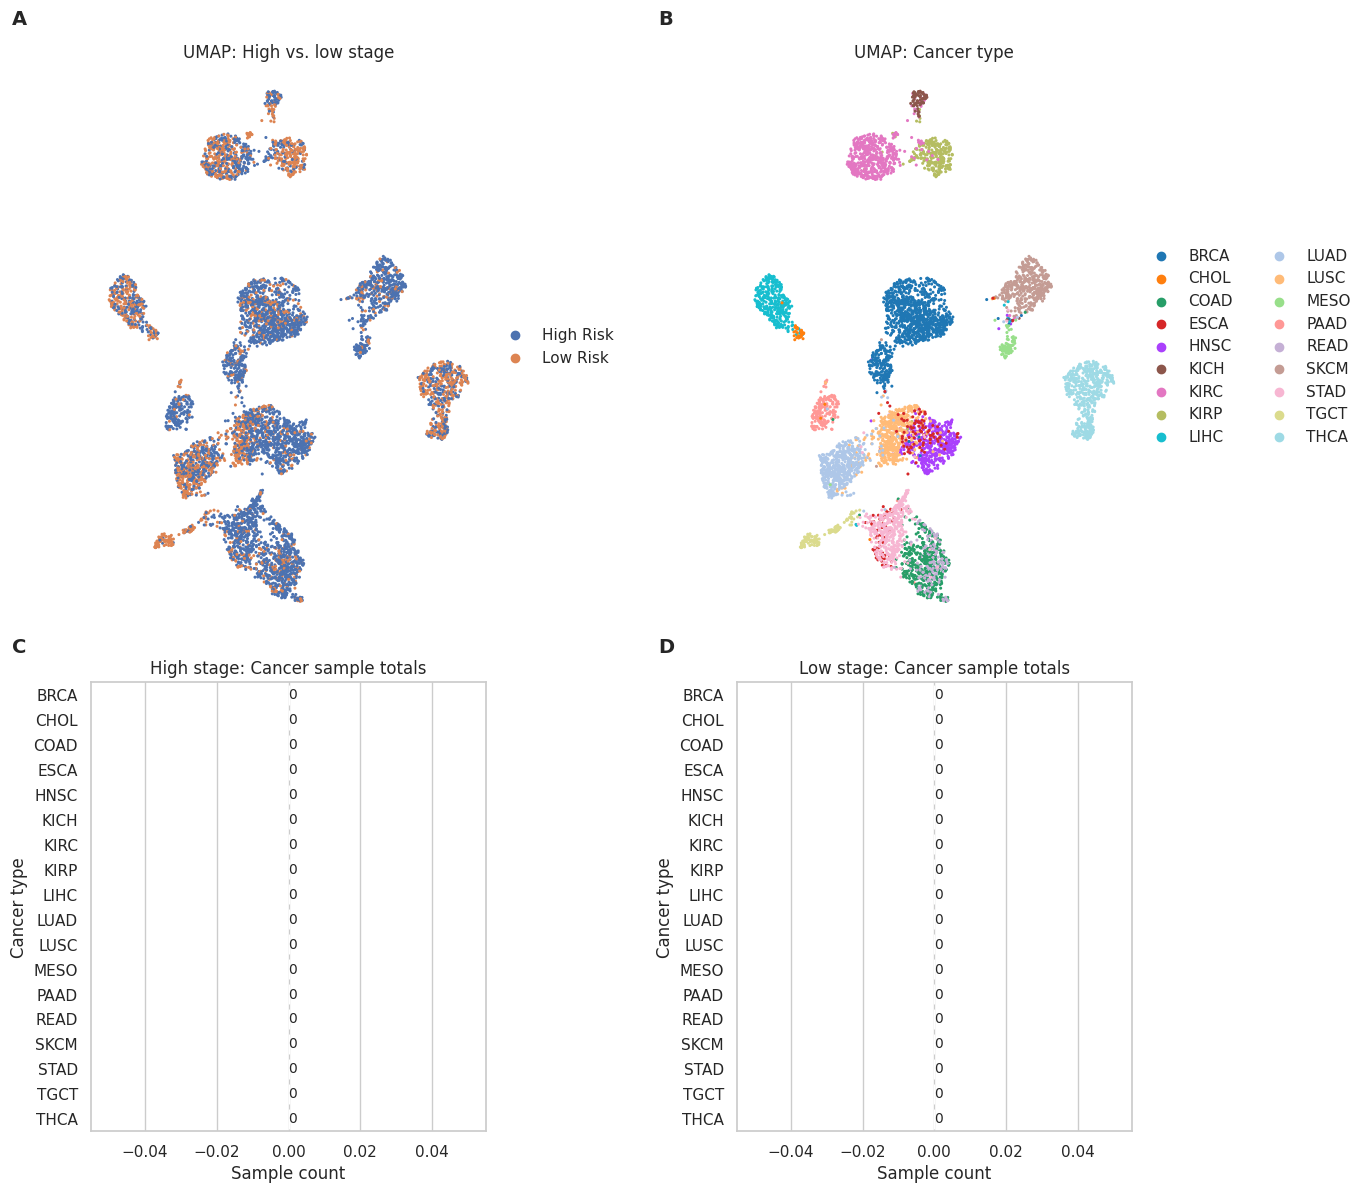

In [12]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# If you haven’t yet, create a clean risk column:
adata.obs['ajcc_simplified_umap'] = adata.obs['ajcc_simplified'].str.lstrip('_')

# Set up figure and grid
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(2, 2,
    height_ratios=[1, 0.8],
    width_ratios=[1, 1],
    figure=fig
)

# helpers
def add_bar_labels(ax, values):
    for i, v in enumerate(values):
        ax.text(v + max(values)*0.02, i, str(v), va='center', fontsize=10)

def add_subplot_label(ax, label, x_pos=0.02, y_pos=0.99):
    ax.text(
        x_pos, y_pos, label,
        transform=ax.transAxes,
        fontsize=14, fontweight='bold',
        va='top', ha='left'
    )

x_left=-0.2
x_right=-0.2
y_top=1.1
y_bottom=1.1
# --- A: UMAP colored by AJCC stage ---
axA = fig.add_subplot(gs[0, 0])
sc.pl.umap(
    adata,
    color='ajcc_simplified_umap',
    ax=axA,
    show=False,
    frameon=False
)
axA.set_title("UMAP: High vs. low stage")
add_subplot_label(axA, "A", x_pos=x_left, y_pos=y_top)

# --- B: UMAP colored by Cell Type ---
axB = fig.add_subplot(gs[0, 1])
sc.pl.umap(
    adata,
    color='type',
    ax=axB,
    show=False,
    frameon=False
)
axB.set_title("UMAP: Cancer type")
add_subplot_label(axB, "B", x_pos=x_right, y_pos=y_top)

# --- C: Bar Chart for High stage ---
axC = fig.add_subplot(gs[1, 0])
high_counts = (
    adata.obs
    .loc[adata.obs['ajcc_simplified_umap'] == 'High stage', 'type']
    .value_counts(ascending=True)
)
sns.barplot(
    x=high_counts.values,
    y=high_counts.index.str.replace("_", " "),
    ax=axC,
    palette="Blues_r"
)
axC.set_title("High stage: Cancer sample totals")
axC.set_xlabel("Sample count")
axC.set_ylabel("Cancer type")
add_bar_labels(axC, high_counts.values)
add_subplot_label(axC, "C", x_pos=x_left, y_pos=y_bottom)

# --- D: Bar Chart for Low Risk ---
axD = fig.add_subplot(gs[1, 1])
low_counts = (
    adata.obs
    .loc[adata.obs['ajcc_simplified_umap'] == 'Low stage', 'type']
    .value_counts(ascending=True)
)
sns.barplot(
    x=low_counts.values,
    y=low_counts.index.str.replace("_", " "),
    ax=axD,
    palette="Reds_r"
)
axD.set_title("Low stage: Cancer sample totals")
axD.set_xlabel("Sample count")
axD.set_ylabel("Cancer type")
add_bar_labels(axD, low_counts.values)
add_subplot_label(axD, "D", x_pos=x_right, y_pos=y_bottom)

# Final layout & save
plt.tight_layout()
plt.show()
fig.savefig(f'{main_path}{analysis_set}/data_plot_split.png')


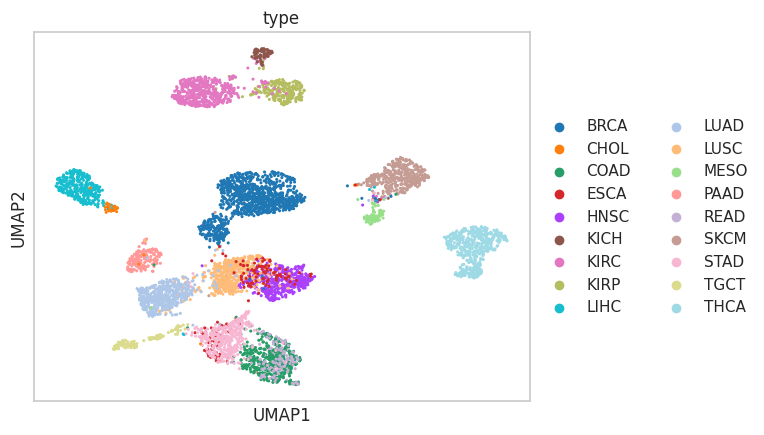

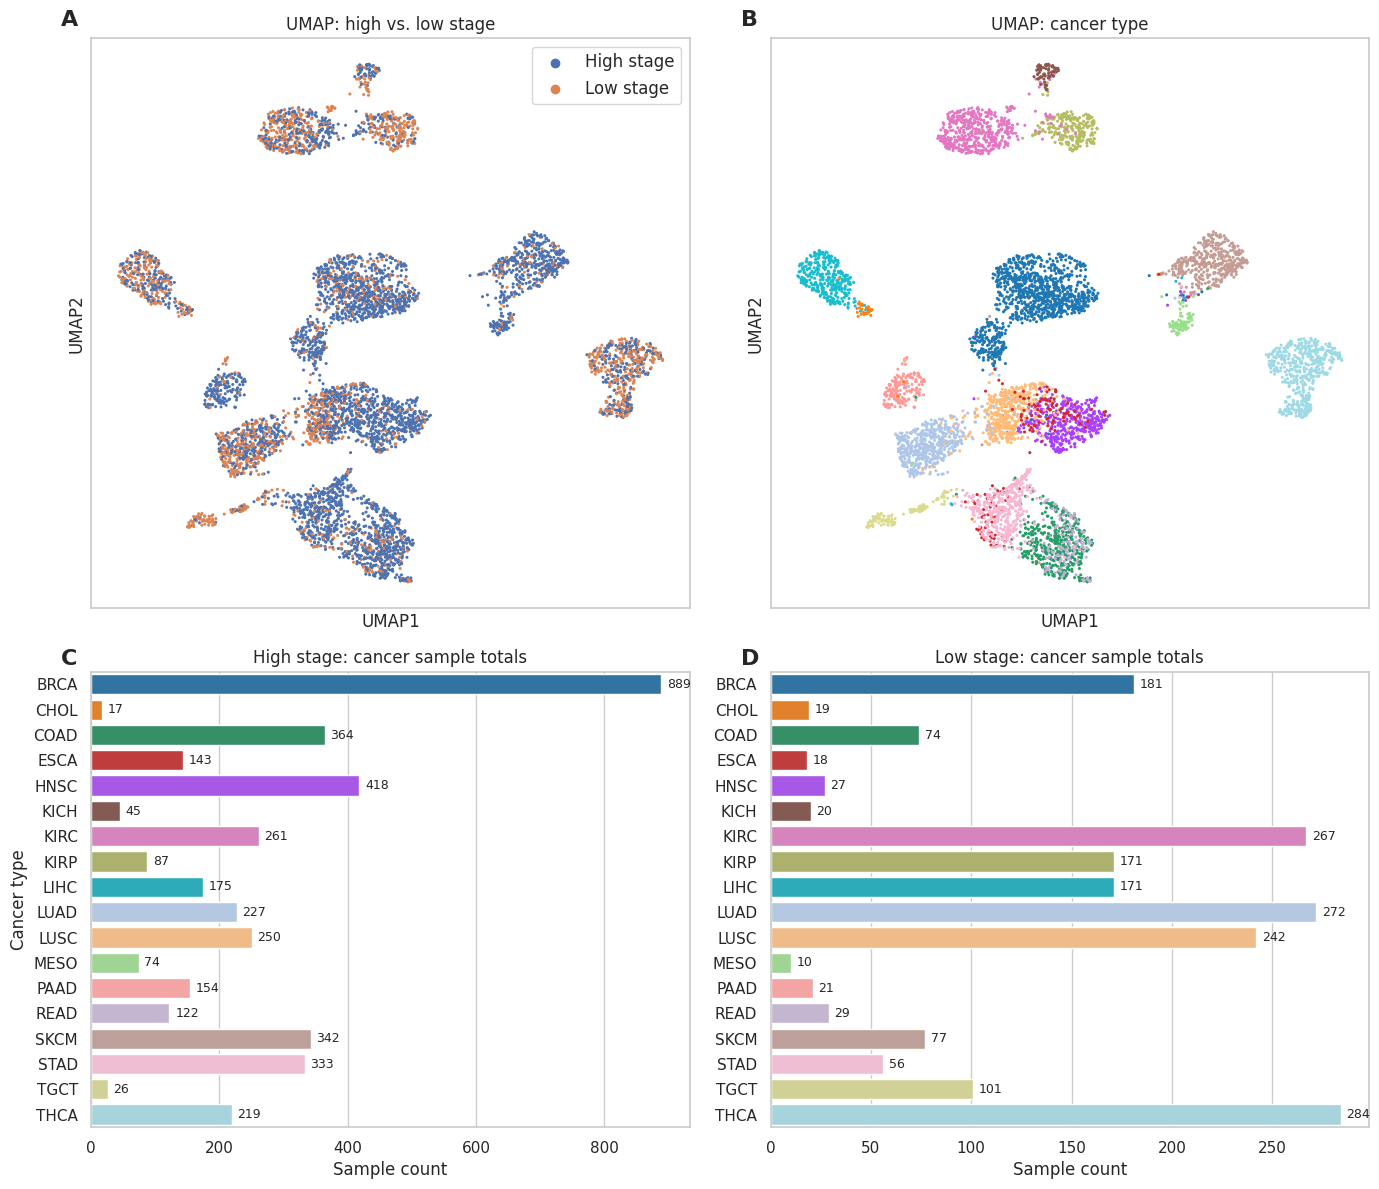

<Figure size 640x480 with 0 Axes>

In [13]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
def add_subplot_label(ax, label, x=0.02, y=0.98, fontsize=16):
    ax.text(
        x, y, label,
        transform=ax.transAxes,
        fontsize=fontsize,
        fontweight='bold',
        va='top', ha='left'
    )
# ─── 0) PREPARE YOUR DATA ────────────────────────────────────────────────
adata.obs['type'] = adata.obs['type'].astype('category')
adata.obs['ajcc_simplified_umap'] = (
    adata.obs['ajcc_simplified']
    .str.lstrip('_')
    .replace({"High Risk": "High stage", "Low Risk": "Low stage"})
)

# ─── 1) BUILD A SINGLE cancer_type  to  color MAPPING ─────────────────────
sc.pl.umap(adata, color='type', show=False)  # hidden UMAP
types_list  = adata.obs['type'].cat.categories.tolist()
colors_list = adata.uns['type_colors']
palette     = dict(zip(types_list, colors_list))

# ─── 2) RE-PLOT ALL FOUR PANELS WITH THAT SAME PALETTE ──────────────────
fig, ((axA, axB),
      (axC, axD)) = plt.subplots(
    2, 2, figsize=(14,12),
    gridspec_kw=dict(height_ratios=[1, .8],
                     width_ratios=[1,1])
)
# A) stage UMAP, legend “on data”
sc.pl.umap(
    adata,
    color='ajcc_simplified_umap',
    ax=axA,
    show=False,
    frameon=True,
    legend_loc='upper right',      # puts the High/Low labels inside the plot
    legend_fontsize=12,
    legend_fontweight='normal'
)
axA.set_title("UMAP: high vs. low stage")


# B) type UMAP, no legend
sc.pl.umap(
    adata,
    color='type',
    palette=palette,
    ax=axB,
    show=False,
    frameon=True,
    legend_loc=None            # turns off the legend
)
axB.set_title("UMAP: cancer type")


# C) High stage barplot
high = (
    adata.obs
        .query("ajcc_simplified_umap=='High stage'")['type']
        .value_counts()
)
df_high = high.rename_axis("type").reset_index(name="count")

sns.barplot(
    data=df_high,
    x="count", y="type",
    hue="type",
    palette=palette,
    dodge=False,
    ax=axC,
    legend=False
)
axC.set_title("High stage: cancer sample totals")
axC.set_xlabel("Sample count")
axC.set_ylabel("Cancer type")

# annotate C
offset = df_high['count'].max() * 0.01
for bar in axC.patches:
    w = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    axC.text(w + offset, y, f"{int(w)}", va='center', fontsize=9)

# D) Low stage barplot
low = (
    adata.obs
        .query("ajcc_simplified_umap=='Low stage'")['type']
        .value_counts()
)
df_low = low.rename_axis("type").reset_index(name="count")

sns.barplot(
    data=df_low,
    x="count", y="type",
    hue="type",
    palette=palette,
    dodge=False,
    ax=axD,
    legend=False
)
axD.set_title("Low stage: cancer sample totals")
axD.set_xlabel("Sample count")
axD.set_ylabel("")

# annotate D
offset = df_low['count'].max() * 0.01
for bar in axD.patches:
    w = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    axD.text(w + offset, y, f"{int(w)}", va='center', fontsize=9)
add_subplot_label(axA, "A",x=-0.05, y=1.05)
add_subplot_label(axB, "B",x=-0.05, y=1.05)
add_subplot_label(axC, "C",x=-0.05, y=1.05)
add_subplot_label(axD, "D",x=-0.05, y=1.05)
plt.tight_layout()
plt.show()
# Final layout & save
plt.tight_layout()
plt.show()
fig.savefig(f'{main_path}{analysis_set}/data_plot_split.png')

In [14]:
import gc
torch.cuda.empty_cache()
gc.collect()
unique_cancers=adata.obs['type'].unique().sort_values()

In [15]:
oracle_pval_col    = 'oracle_score_pval_acat_fdr'
survival_pval_col  = 'survival_score_pval_acat_fdr'
oracle_score_col   = 'oracle_score'
survival_score_col = 'survival_score'
pval_threshold     = 0.1

from statsmodels.stats.multitest import multipletests


In [16]:
analysis_set="pancancer_tcga"
passing_sets_high_to_low={}
for cancer in unique_cancers:
    group_high=cancer+"_High Risk"
    group_low = cancer+"_Low Risk"
    temp=pd.read_csv(f'{main_path}{analysis_set}/from_{group_high}_to_{group_low}/summary_statistics.csv')
    categories_to_keep = 10 #number of cell types I want to keep in the model sorted by decreasing cell count, can use all but only so much weighted losses can do...

    # build the mask
    mask = (
        (temp[oracle_pval_col]   < pval_threshold) &
        (temp[survival_pval_col] < pval_threshold) &
        (temp[oracle_score_col]  > 0) &
        (temp[survival_score_col]> 0)
    )
    
    # apply it
    filtered = temp[mask]
    
    filtered
    gene_list = (
        filtered
        .apply(lambda row: f"{'+' if row['suggested_perturbation'] > 0 else '-'}{row['gene_name']}",
               axis=1)
        .tolist()
    )
    
    passing_sets_high_to_low[f'{cancer}']=gene_list 

/home/jislam/.local/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/jislam/.local/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=Tru

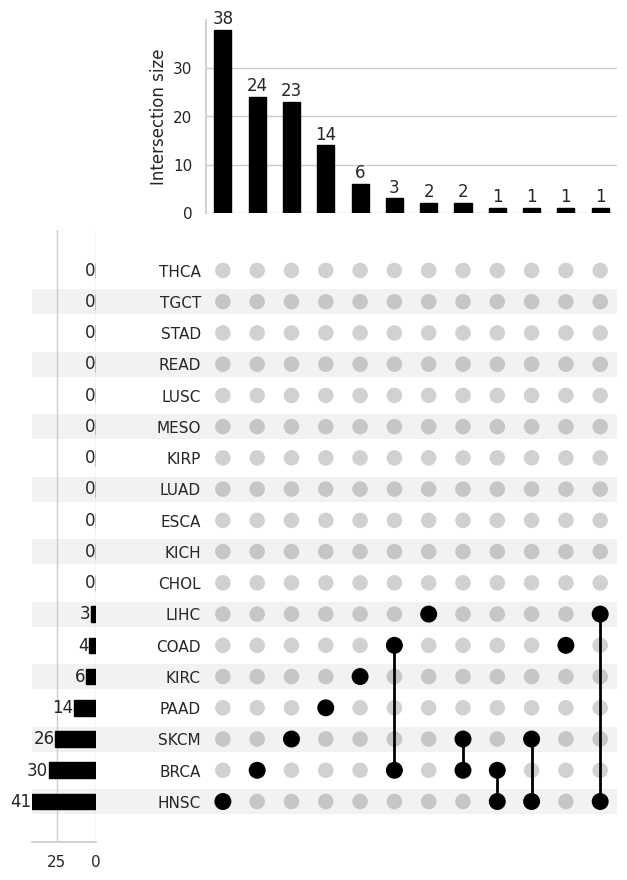

In [17]:
from upsetplot import from_contents, UpSet
import matplotlib.pyplot as plt

# your dict of lists (or sets)


# convert to the multi‐index format upsetplot wants
data = from_contents(passing_sets_high_to_low)

# plot!
up = UpSet(data,sort_by='cardinality',min_degree=1,   show_counts=True)
up.plot()
plt.tight_layout()

plt.savefig("High_to_low_stage_upset.png", dpi=300, bbox_inches="tight")
plt.show()

In [18]:
analysis_set="pancancer_tcga"
passing_sets_low_to_high={}
for cancer in unique_cancers:
    group_high=cancer+"_High Risk"
    group_low = cancer+"_Low Risk"
    temp=pd.read_csv(f'{main_path}{analysis_set}/from_{group_low}_to_{group_high}/summary_statistics.csv')
        # your variable names

    
    # build the mask
    mask = (
        (temp[oracle_pval_col]   < pval_threshold) &
        (temp[survival_pval_col] < pval_threshold) &
        (temp[oracle_score_col]  > 0) &
        (temp[survival_score_col]< 0)
    )
    
    # apply it
    filtered = temp[mask]
    
    filtered
    gene_list = (
        filtered
        .apply(lambda row: f"{'+' if row['suggested_perturbation'] > 0 else '-'}{row['gene_name']}",
               axis=1)
        .tolist()
    )
    
    passing_sets_low_to_high[f'{cancer}']=gene_list 

/home/jislam/.local/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/jislam/.local/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=Tru

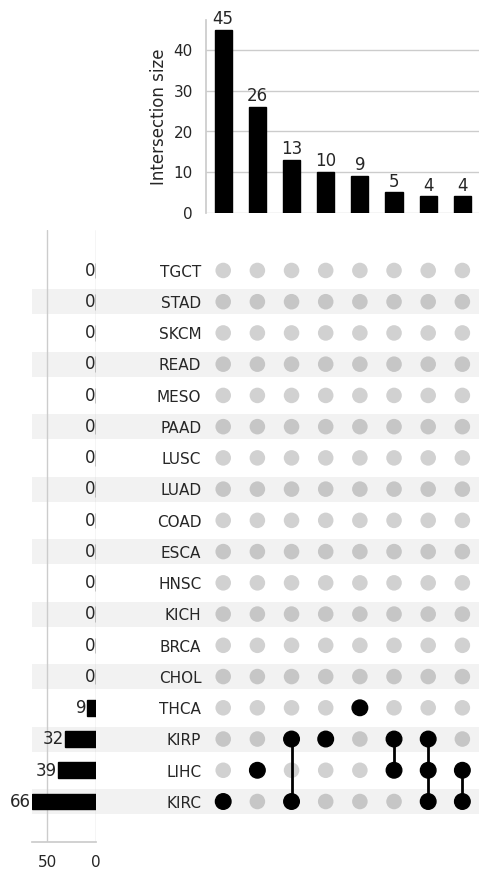

In [19]:
from upsetplot import from_contents, UpSet
import matplotlib.pyplot as plt

# your dict of lists (or sets)


# convert to the multi‐index format upsetplot wants
data = from_contents(passing_sets_low_to_high)

# plot!
up = UpSet(data,sort_by='cardinality',min_degree=1,   show_counts=True)
up.plot()
plt.tight_layout()

plt.savefig("Low_to_high_stage_upset.png", dpi=300, bbox_inches="tight")
plt.show()

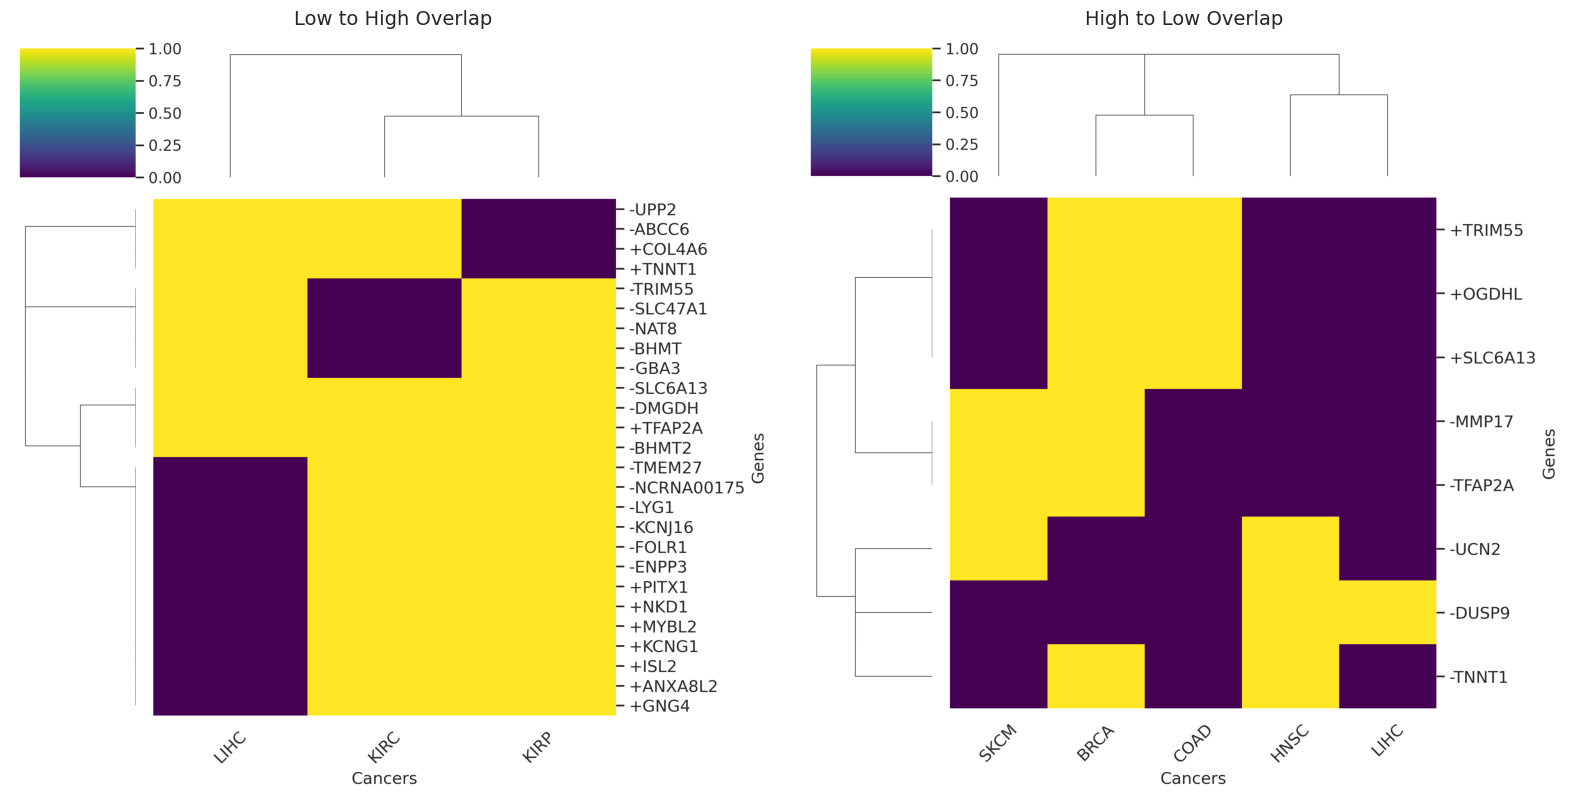

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from adjustText import adjust_text
from io import BytesIO
from PIL import Image

def plot_cancer_gene_clustermap(passing_sets: dict,
                                metric: str = "jaccard",
                                method: str = "average",
                                figsize: tuple = (10, 10),
                                cmap: str = None,
                                figsize_dendro_ratio: float = 0.2,
                                cluster_rows: bool = True,
                                cluster_cols: bool = True,
                                title: str = "cancer x gene",
                                **clustermap_kwargs):
    """
    Build and plot a clustered cancer×gene presence heatmap, showing only genes
    present in more than one cancer list and dropping cancers that become empty.

    Parameters
    ----------
    passing_sets : dict
        Keys = cancer names, values = iterable of genes.
    metric : str
        Distance metric for linkage (e.g. 'euclidean', 'jaccard').
    method : str
        Linkage method (e.g. 'average', 'complete').
    figsize : tuple
        Overall figure size (width, height).
    cmap : str or Colormap
        Colormap for the heatmap. If None, seaborn default is used.
    figsize_dendro_ratio : float
        Fraction of figure height/width reserved for dendrograms.
    cluster_rows : bool
        If True, reorder cancer rows by hierarchical clustering.
    cluster_cols : bool
        If True, reorder gene columns by hierarchical clustering.
    title : str
        Title for the heatmap.
    **clustermap_kwargs :
        Additional kwargs for seaborn.clustermap.

    Returns
    -------
    g : seaborn.matrix.ClusterGrid
    """
    # 0) Drop cancers with no genes
    filtered_sets = {c: genes for c, genes in passing_sets.items() if genes}
    if not filtered_sets:
        raise ValueError("No cancers with non-empty gene lists to plot.")

    # 1) Identify genes present in more than one cancer
    gene_counts = Counter(g for genes in filtered_sets.values() for g in genes)
    multi_genes = [g for g, count in gene_counts.items() if count > 1]
    if not multi_genes:
        raise ValueError("No genes present in more than one cancer list.")

    # 2) Filter each cancer's gene list to only those multi-list genes
    filtered_sets = {c: [g for g in genes if g in multi_genes]
                     for c, genes in filtered_sets.items()}

    # 3) Drop cancers that now have no genes
    filtered_sets = {c: genes for c, genes in filtered_sets.items() if genes}
    if not filtered_sets:
        raise ValueError("All cancers were dropped after filtering genes present in more than one list.")

    # 4) Build binary indicator matrix
    all_genes = sorted(multi_genes)
    df = pd.DataFrame(0,
                      index=filtered_sets.keys(),
                      columns=all_genes,
                      dtype=int)
    for cancer, genes in filtered_sets.items():
        df.loc[cancer, genes] = 1

    # 5) Plot via seaborn clustermap
    g = sns.clustermap(df.T,
                       metric=metric,
                       method=method,
                       cmap=cmap,
                       figsize=figsize,
                       dendrogram_ratio=(figsize_dendro_ratio, figsize_dendro_ratio),
                       cbar_pos=(0.02, 0.8, 0.05, 0.18),
                       row_cluster=cluster_rows,
                       col_cluster=cluster_cols,
                       xticklabels=True,
                       yticklabels=True,
                       **clustermap_kwargs)

    # 6) Aesthetics
    g.ax_heatmap.set_xlabel("Cancers")
    g.ax_heatmap.set_ylabel("Genes")
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, fontsize=12)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=12)
    #g.ax_heatmap.set_title(title)
    plt.tight_layout()

    return g


def multiplot_cancer_gene_clustermaps(
        map_configs: list,
        metric: str = "jaccard",
        method: str = "average",
        cmap: str = None,
        figsize: tuple = (10, 10),
        figsize_dendro_ratio: float = 0.2,
        cluster_rows: bool = True,
        cluster_cols: bool = True,
        **clustermap_kwargs):
    """
    Generate multiple cancer×gene clustermaps side by side in one figure.

    Parameters
    ----------
    map_configs : list of dicts
        Each dict must have:
            - 'passing_sets': dict of cancer to genes
            - 'title': str for the subplot title
    Other parameters are passed to plot_cancer_gene_clustermap.

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure containing all clustermap subplots.
    """
    # Collect rendered images of each clustermap
    images = []
    titles = []
    for cfg in map_configs:
        ps = cfg['passing_sets']
        ttl = cfg.get('title', 'cancer x gene')
        g = plot_cancer_gene_clustermap(
            ps,
            metric=metric,
            method=method,
            figsize=figsize,
            cmap=cmap,
            figsize_dendro_ratio=figsize_dendro_ratio,
            cluster_rows=cluster_rows,
            cluster_cols=cluster_cols,
            title=ttl,
            **clustermap_kwargs
        )
        buf = BytesIO()
        g.fig.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        buf.seek(0)
        images.append(Image.open(buf))
        titles.append(ttl)
        plt.close(g.fig)

    # Create a new figure to display all images
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(figsize[0] * n, figsize[1]))
    if n == 1:
        axes = [axes]

    for ax, img, ttl in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(ttl, fontsize=14)
        ax.axis('off')

    plt.tight_layout()
    return fig
fig = multiplot_cancer_gene_clustermaps([
    {'passing_sets': passing_sets_low_to_high, 'title': 'Low to High Overlap'},
    {'passing_sets': passing_sets_high_to_low, 'title': 'High to Low Overlap'}
],
metric='jaccard', method='complete', cmap='viridis', figsize=(8,8))
fig.savefig('both_stage_overlaps.png', dpi=300, bbox_inches='tight')


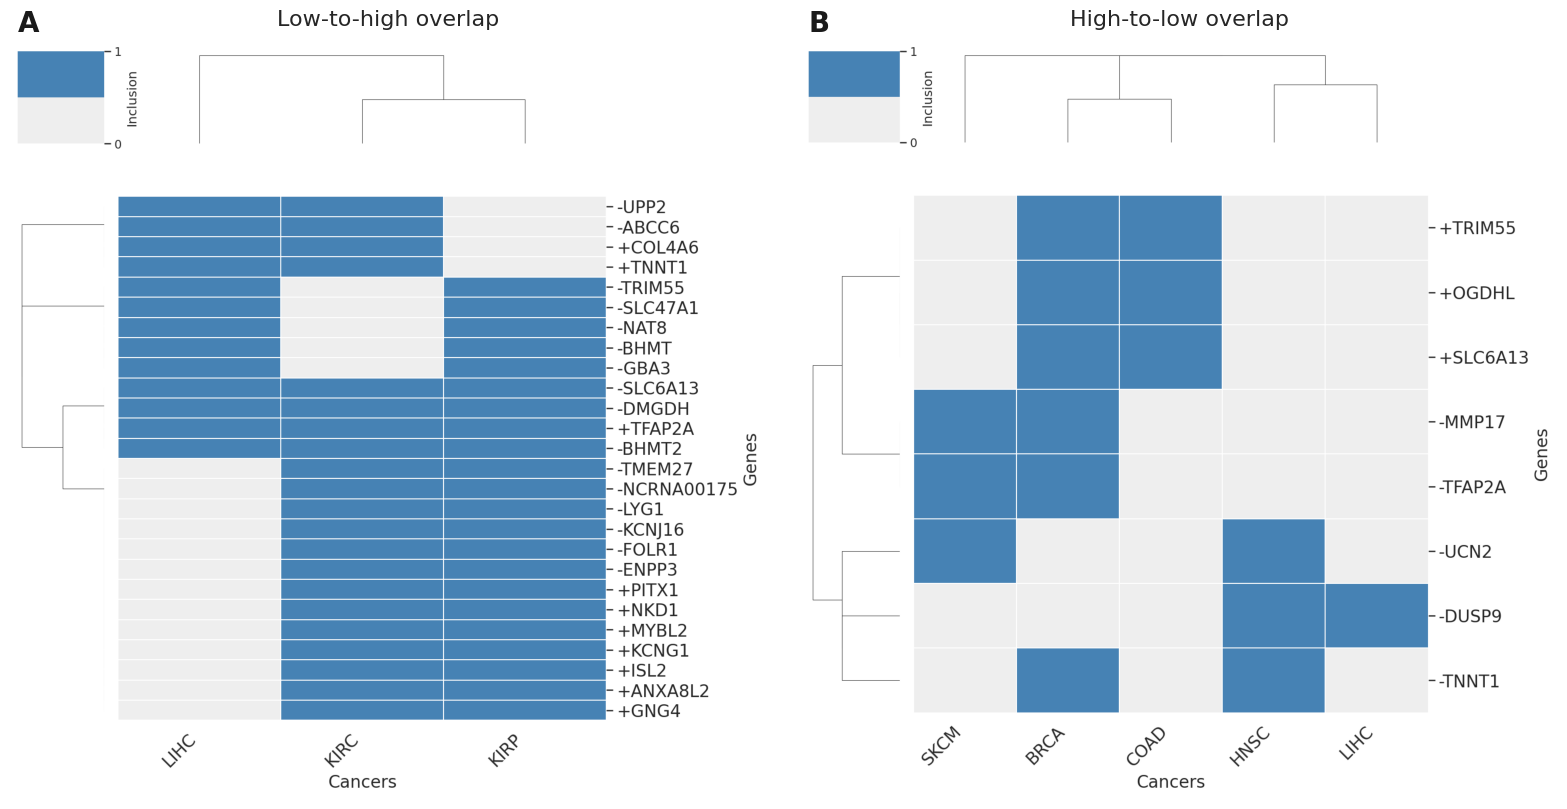

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from io import BytesIO
from PIL import Image

# 1) Update the single-map function to force binary coloring:
def plot_cancer_gene_clustermap(passing_sets: dict,
                                metric: str = "jaccard",
                                method: str = "average",
                                figsize: tuple = (8, 8),
                                figsize_dendro_ratio: float = 0.15,
                                cluster_rows: bool = True,
                                cluster_cols: bool = True,
                                cmap=None,
                                title: str = "cancer × gene",
                                **clustermap_kwargs):
    # … [0–4 are exactly as before: filter, build df] …
    # 0) Drop cancers with no genes
    filtered_sets = {c: genes for c, genes in passing_sets.items() if genes}
    if not filtered_sets:
        raise ValueError("No cancers with non-empty gene lists to plot.")

    # 1) Identify genes present in more than one cancer
    gene_counts = Counter(g for genes in filtered_sets.values() for g in genes)
    multi_genes = [g for g, count in gene_counts.items() if count > 1]
    if not multi_genes:
        raise ValueError("No genes present in more than one cancer list.")

    # 2) Filter each cancer's gene list to only those multi-list genes
    filtered_sets = {c: [g for g in genes if g in multi_genes]
                     for c, genes in filtered_sets.items()}

    # 3) Drop cancers that now have no genes
    filtered_sets = {c: genes for c, genes in filtered_sets.items() if genes}
    if not filtered_sets:
        raise ValueError("All cancers were dropped after filtering genes present in more than one list.")

    # 4) Build binary indicator matrix
    all_genes = sorted(multi_genes)
    df = pd.DataFrame(0,
                      index=filtered_sets.keys(),
                      columns=all_genes,
                      dtype=int)
    for cancer, genes in filtered_sets.items():
        df.loc[cancer, genes] = 1
    # make sure we only have 0/1, and pick a two-color palette if none given
    if cmap is None:
        cmap = ListedColormap(["#EEEEEE", "steelblue"])
    # draw
    g = sns.clustermap(
        df.T,
        metric=metric,
        method=method,
        cmap=cmap,
        vmin=0, vmax=1,
        linewidths=0.2,        # ← thickness of the grid lines
        linecolor="white",     # ← color of the grid lines
        dendrogram_ratio=(figsize_dendro_ratio, figsize_dendro_ratio),
        cbar_pos=(0.02, 0.8, 0.05, 0.18),
        cbar_kws={"ticks": [0, 1], "label": "Inclusion"},
        row_cluster=cluster_rows,
        col_cluster=cluster_cols,
        xticklabels=True,
        yticklabels=True,
        **clustermap_kwargs
    )

    # labels & ticks
    g.ax_heatmap.set_xlabel("Cancers", fontsize=16)
    g.ax_heatmap.set_ylabel("Genes", fontsize=16)
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", fontsize=16)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=16)

    # optional title on the heatmap itself
    #g.ax_heatmap.set_title(title, fontsize=18, pad=20)

    # tighten up
    plt.tight_layout()
    return g


# 2) Update the multiplot wrapper to stamp "A", "B", … on each panel
def multiplot_cancer_gene_clustermaps(map_configs: list,
                                      metric: str = "jaccard",
                                      method: str = "complete",
                                      figsize: tuple = (8, 8),
                                      figsize_dendro_ratio: float = 0.15,
                                      cluster_rows: bool = True,
                                      cluster_cols: bool = True,
                                      cmap=None,
                                      **clustermap_kwargs):
    images = []
    titles = []
    for cfg in map_configs:
        g = plot_cancer_gene_clustermap(
            cfg["passing_sets"],
            metric=metric,
            method=method,
            figsize=figsize,
            figsize_dendro_ratio=figsize_dendro_ratio,
            cluster_rows=cluster_rows,
            cluster_cols=cluster_cols,
            cmap=cmap,
            title=cfg.get("title", ""),
            **clustermap_kwargs
        )
        buf = BytesIO()
        g.fig.savefig(buf, format="png", dpi=150, bbox_inches="tight")
        buf.seek(0)
        images.append(Image.open(buf))
        titles.append(cfg.get("title", ""))
        plt.close(g.fig)

    # now lay them out side by side
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(figsize[0] * n, figsize[1]))
    if n == 1:
        axes = [axes]

    for i, (ax, img, ttl) in enumerate(zip(axes, images, titles)):
        ax.imshow(img)
        ax.axis("off")
        # draw panel letter
        letter = chr(ord("A") + i)
        ax.text(
            0.01, 1.04,
            letter,
            transform=ax.transAxes,
            fontsize=20,
            fontweight="bold",
            va="top",
            ha="left",
            color="k",
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7)
        )
        # optional overall sub-title
        ax.set_title(ttl, fontsize=16, pad=10)

    plt.tight_layout()
    return fig


# 3) And finally, call it exactly as before:
fig = multiplot_cancer_gene_clustermaps([
    {"passing_sets": passing_sets_low_to_high,  "title": "Low-to-high overlap"},
    {"passing_sets": passing_sets_high_to_low,  "title": "High-to-low overlap"}
],
metric="jaccard",
method="complete",
figsize=(8, 8))
fig.savefig("both_stage_overlaps.png", dpi=300, bbox_inches="tight")


In [8]:

import gc
torch.cuda.empty_cache()
gc.collect()
#simulation_results={}
min_layer_size_star=int(adata.shape[1]*2/16)
max_layer_size_star=int(adata.shape[1]*8/16)


min_layer_size_oracle=int(adata.shape[1]*2/16)
max_layer_size_oracle=int(adata.shape[1]*8/16)

min_layer_size_prop=int(adata.shape[1]*2/16)
max_layer_size_prop=int(adata.shape[1]*8/16)


bsize=1024

from copy import deepcopy

category_labels=[filter_by] 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



###########################################################################################
###########################################################################################
#### Stargan
###########################################################################################
###########################################################################################         
stargan_hyperparameter_ranges = optuna.create_study(storage="sqlite:///"+outdir+"/"+analysis_set.replace(" ","_")+"_SIMULATION_stargan.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=analysis_set.replace(" ", "_")+"_stargan_SIMULATION_"+"_main.db",
                            load_if_exists=True)


# Get the best hyperparameters
best_params = stargan_hyperparameter_ranges.best_params

stargan_hyperparam = {
    'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes_generator': [
        best_params["gen_layer0"],
        best_params["gen_layer1"],
        best_params["gen_layer2"]
    ],
    'layer_nodes_discriminator': [
        best_params["disc_layer0"],
        best_params["disc_layer1"],
        best_params["disc_layer2"]
    ],
    'critics': 3,

    "dropout_rate":best_params["dropout_rate"]
}

###########################################################################################
###########################################################################################
#### Oracle
###########################################################################################
###########################################################################################


oracle_hyperparameter_ranges = optuna.create_study(storage="sqlite:///"+outdir+"/"+analysis_set.replace(" ","_")+"_SIMULATION_oracle.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=analysis_set.replace(" ", "_")+"_oracle_SIMULATION_"+"main.db",
                            load_if_exists=True)
best_params = oracle_hyperparameter_ranges.best_params
print("Best hyperparameters:", best_params)
oracle_hyperparam = {'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes': [
        best_params["disc_layer0"],
        best_params["disc_layer1"],
        best_params["disc_layer2"]
    ],
    'dropout_rate_d': best_params['disc_dropout_rate']
}
   
###########################################################################################
###########################################################################################
#### Propagator
###########################################################################################
###########################################################################################

propagator_hyperparameter_ranges = optuna.create_study(storage="sqlite:///"+outdir+"/"+analysis_set.replace(" ","_")+"_SIMULATION_propagator.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=analysis_set.replace(" ", "_")+"_propagator_SIMULATION_"+"main.db",
                            load_if_exists=True)

start_time=time.time()
# Get the best hyperparameters
best_params = propagator_hyperparameter_ranges.best_params
print("Best hyperparameters:", best_params)

propagator_hyperparam = {
    'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes_generator': [
        best_params["gen_layer0"],
        best_params["gen_layer1"],
        best_params["gen_layer2"]
    ],
    'dropout_rate_g': best_params['gen_dropout_rate'],
    'latent_dim':best_params['latent'],
    'beta':float(best_params['beta'])
    
}


shared_filter = None
filter_criteria_start = ["start"]
filter_criteria_goal  = ["goal"]

import json
with open(f'{main_path}{analysis_set}/stargan_hyperparam_selected.json', 'w') as f:
    json.dump(stargan_hyperparam, f)

with open(f'{main_path}{analysis_set}/propagator_hyperparam_selected.json', 'w') as f:
    json.dump(propagator_hyperparam, f)

with open(f'{main_path}{analysis_set}/oracle_hyperparam_selected.json', 'w') as f:
    json.dump(oracle_hyperparam, f)



def convert_distributions_to_string(input_dict):
    # Create a new dictionary to store the updated values
    output_dict = {}
    
    for key, value in input_dict.items():
        output_dict[key] = str(value)  # for other types, store the original value

    return output_dict




import json
with open(f'{main_path}{analysis_set}/stargan_hyperparam_ranges.json', 'w') as f:
    json.dump(convert_distributions_to_string(stargan_hyperparameter_ranges.trials[0].distributions), f)

with open(f'{main_path}{analysis_set}/propagator_hyperparam_ranges.json', 'w') as f:
    json.dump(convert_distributions_to_string(propagator_hyperparameter_ranges.trials[0].distributions), f)

with open(f'{main_path}{analysis_set}/oracle_hyperparam_ranges.json', 'w') as f:
    json.dump(convert_distributions_to_string(oracle_hyperparameter_ranges.trials[0].distributions), f)

[I 2025-08-11 22:28:45,318] Using an existing study with name 'pancancer_tcga_stargan_SIMULATION__main.db' instead of creating a new one.
[I 2025-08-11 22:28:45,346] Using an existing study with name 'pancancer_tcga_oracle_SIMULATION_main.db' instead of creating a new one.
[I 2025-08-11 22:28:45,377] Using an existing study with name 'pancancer_tcga_propagator_SIMULATION_main.db' instead of creating a new one.


Best hyperparameters: {'batch_size': 1024, 'learning_rate': 1.9457260288494707e-05, 'disc_layer0': 888, 'disc_layer1': 454, 'disc_layer2': 689, 'disc_dropout_rate': 0.009425566768648265}
Best hyperparameters: {'batch_size': 1024, 'learning_rate': 0.000745139047193172, 'gen_layer0': 881, 'gen_layer1': 260, 'gen_layer2': 779, 'gen_dropout_rate': 0.013585020849545533, 'latent': 7, 'beta': 1}


In [14]:
#single cell data should be removed eventually, its vestigial from before
study_name =  "pancancer_tcga_pan_tcga_CBNN.db"
db_path = f"sqlite:///{outdir}/{study_name}"

# Create or load existing study
cbnn_hyperparameter_ranges = optuna.create_study(
    storage=db_path,
    direction='minimize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=min_optuna,
        max_resource=hyperparam_epochs,
        reduction_factor=5
    ),
    study_name=study_name,
    load_if_exists=True
)
best_params = cbnn_hyperparameter_ranges.best_params

cbnn_hyperparam = {
    'batch_size': best_params['batch_size'],
    'learning_rate': best_params['lr'],
    'layer_nodes': [best_params["layer0"], best_params["layer1"], best_params["layer2"]],
    'dropout_rate': best_params['dropout']
}


import json
with open(f'{main_path}{analysis_set}/cbnn_hyperparam_selected.json', 'w') as f:
    json.dump(cbnn_hyperparam, f)
with open(f'{main_path}{analysis_set}/cbnn_hyperparam_ranges.json', 'w') as f:
    json.dump(convert_distributions_to_string(cbnn_hyperparameter_ranges.trials[0].distributions), f)

[I 2025-08-11 22:56:19,050] Using an existing study with name 'pancancer_tcga_pan_tcga_CBNN.db' instead of creating a new one.


FrozenTrial(number=50, state=TrialState.PRUNED, values=[0.05519493296742439], datetime_start=datetime.datetime(2025, 5, 16, 19, 18, 24, 896105), datetime_complete=datetime.datetime(2025, 5, 16, 19, 18, 49, 406582), params={'lr': 2.4948067465147244e-05, 'dropout': 0.11638517863253822, 'layer0': 606, 'layer1': 744, 'layer2': 296, 'batch_size': 1962}, user_attrs={}, system_attrs={'completed_rung_0': 0.05519493296742439}, intermediate_values={0: 0.05964500084519386, 1: 0.05895182490348816, 2: 0.057949185371398926, 3: 0.057118989527225494, 4: 0.0576632097363472, 5: 0.056480105966329575, 6: 0.05588342249393463, 7: 0.05562788248062134, 8: 0.05590781942009926, 9: 0.055328380316495895, 10: 0.05519493296742439}, distributions={'lr': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'dropout': FloatDistribution(high=0.3, log=False, low=0.0, step=None), 'layer0': IntDistribution(high=1000, log=False, low=250, step=1), 'layer1': IntDistribution(high=1000, log=False, low=250, step=1), '